In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("nih-chest-xrays/sample")

print("Path to dataset files:", path)

100%|██████████| 4.20G/4.20G [00:37<00:00, 120MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/nih-chest-xrays/sample/versions/4


In [3]:
import pandas as pd
df=pd.read_csv("/root/.cache/kagglehub/datasets/nih-chest-xrays/sample/versions/4/sample_labels.csv")
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [5]:
import os
import pandas as pd

# Path to dataset (Kaggle auto mounts it here)
DATA_DIR = "/root/.cache/kagglehub/datasets/nih-chest-xrays/sample/versions/4/sample"

# Check files
os.listdir(DATA_DIR)
# Load metadata
df = pd.read_csv(os.path.join(DATA_DIR, "sample_labels.csv"))

# Keep only images that exist in the sample images folder
all_images = set(os.listdir(os.path.join(DATA_DIR, "images")))
df = df[df["Image Index"].isin(all_images)]

print(df.shape)
df.head()
df=df[['Image Index','Finding Labels']]

(5606, 11)


In [6]:
# Split labels
all_labels = set()
for tags in df["Finding Labels"]:
    for tag in tags.split("|"):
        all_labels.add(tag.strip())

all_labels = sorted(list(all_labels))
print("Classes:", all_labels, "Total:", len(all_labels))

# Multi-hot encode labels
for label in all_labels:
    df[label] = df["Finding Labels"].apply(lambda x: 1 if label in x else 0)

df.head()


Classes: ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'] Total: 15


,Image Index,Finding Labels,Atelectasis,Cardiomegaly,Consolidation,Edema,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1
1,00000013_026.png,Cardiomegaly|Emphysema,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,00000017_001.png,No Finding,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,00000030_001.png,Atelectasis,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,00000032_001.png,Cardiomegaly|Edema|Effusion,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0


In [20]:
from sklearn.model_selection import train_test_split
df1=df.drop("Finding Labels",axis=1)

train_df, val_df = train_test_split(
    df1, test_size=0.2, random_state=42
)
print("Train:", train_df.shape, "Val:", val_df.shape)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Use the actual label columns from the training data
y_train_labels = train_df[all_labels].values

classes = np.array([0, 1])  # 0=Normal, 1=Disease
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_labels.flatten()  # Flatten the array as compute_class_weight expects a 1D array
)
class_weights = dict(zip(classes, class_weights))
print("Class Weights:", class_weights)

Train: (4484, 16) Val: (1122, 16)
Class Weights: {np.int64(0): np.float64(0.5452334630350194), np.int64(1): np.float64(6.026881720430108)}


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (128, 128)   # can be adjusted based on dataset
BATCH_SIZE = 32

# ✅ Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    samplewise_center=True,
    samplewise_std_normalization=True,
    rotation_range=15,          # random rotation (degrees)
    width_shift_range=0.1,      # horizontal shift
    height_shift_range=0.1,     # vertical shift
    shear_range=0.1,            # shearing transformation
    zoom_range=0.1,             # zoom in/out
    horizontal_flip=True,       # flip images horizontally
    fill_mode='nearest'         # how to fill missing pixels after transform
)

# ✅ Validation generator (NO augmentation, only normalization)
val_datagen = ImageDataGenerator(
    rescale=1./255,
    samplewise_center=True,
    samplewise_std_normalization=True
)

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=os.path.join(DATA_DIR, "images"),
    x_col="Image Index",
    y_col=all_labels,
    target_size=IMG_SIZE,
    class_mode="raw",   # multilabel output
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=os.path.join(DATA_DIR, "images"),
    x_col="Image Index",
    y_col=all_labels,
    target_size=IMG_SIZE,
    class_mode="raw",
    batch_size=BATCH_SIZE,
    shuffle=False
)


Found 4484 validated image filenames.
Found 1122 validated image filenames.


In [22]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# -------------------------------
# Parameters
# -------------------------------
IMG_SIZE = (128, 128)
NUM_CLASSES = len(all_labels)   # your multi-label disease classes

# -------------------------------
# Build MobileNetV2 base
# -------------------------------
base_model = MobileNetV2(input_shape=(*IMG_SIZE, 3),
                         include_top=False,
                         weights="imagenet")

# Freeze all layers initially (Phase 1)
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation=None)(x)    # no activation yet
x = layers.BatchNormalization()(x)           # normalize activations
x = layers.Activation('relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation="sigmoid")(x)   # multi-label → sigmoid

model = Model(inputs=base_model.input, outputs=output)

# Compile
model.compile(optimizer=Adam(1e-3),
              loss="binary_crossentropy",
              metrics=[
                  tf.keras.metrics.AUC(curve="ROC", multi_label=True, name="AUC"),
                  tf.keras.metrics.Precision(name="precision"),
                  tf.keras.metrics.Recall(name="recall")
              ])

# -------------------------------
# Callbacks
# -------------------------------
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6),
    ModelCheckpoint("best_mobilenet.h5", save_best_only=True, monitor="val_loss")
]

# -------------------------------
# Phase 1: Train head only
# -------------------------------
print("🔹 Phase 1: Training classifier head...")
history1 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,   # just enough to stabilize head
    class_weight=class_weights,
    callbacks=callbacks
)

# -------------------------------
# Phase 2: Fine-tune last 10 layers
# -------------------------------
print("🔹 Phase 2: Fine-tuning last 10 layers...")
for layer in base_model.layers[-10:]:
    layer.trainable = True

# Recompile with lower LR for fine-tuning
model.compile(optimizer=Adam(1e-5),
              loss="binary_crossentropy",
              metrics=[
                  tf.keras.metrics.AUC(curve="ROC", multi_label=True, name="AUC"),
                  tf.keras.metrics.Precision(name="precision"),
                  tf.keras.metrics.Recall(name="recall")
              ])


history2 = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=15,   # more epochs for fine-tuning
    class_weight=class_weights,
    callbacks=callbacks
)


🔹 Phase 1: Training classifier head...
Epoch 1/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 584ms/step - AUC: 0.5467 - loss: 0.3809 - precision: 0.3063 - recall: 0.3212

141/141 ━━━━━━━━━━━━━━━━━━━━ 119s 765ms/step - AUC: 0.5470 - loss: 0.3803 - precision: 0.3071 - recall: 0.3211 - val_AUC: 0.6218 - val_loss: 0.2611 - val_precision: 0.6282 - val_recall: 0.2997 - learning_rate: 0.0010
Epoch 2/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 554ms/step - AUC: 0.6473 - loss: 0.2387 - precision: 0.5844 - recall: 0.2986

141/141 ━━━━━━━━━━━━━━━━━━━━ 94s 668ms/step - AUC: 0.6473 - loss: 0.2387 - precision: 0.5843 - recall: 0.2986 - val_AUC: 0.6358 - val_loss: 0.2453 - val_precision: 0.5487 - val_recall: 0.3140 - learning_rate: 0.0010
Epoch 3/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - AUC: 0.6943 - loss: 0.2172 - precision: 0.6081 - recall: 0.3255

141/141 ━━━━━━━━━━━━━━━━━━━━ 94s 667ms/step - AUC: 0.6943 - loss: 0.2172 - precision: 0.6081 - recall: 0.3255 - val_AUC: 0.6443 - val_loss: 0.2251 - val_precision: 0.5611 - val_recall: 0.3054 - learning_rate: 0.0010
Epoch 4/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 94s 667ms/step - AUC: 0.7111 - loss: 0.2201 - precision: 0.6200 - recall: 0.3204 - val_AUC: 0.6511 - val_loss: 0.2319 - val_precision: 0.5479 - val_recall: 0.2904 - learning_rate: 0.0010
Epoch 5/5
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 552ms/step - AUC: 0.7053 - loss: 0.2117 - precision: 0.6367 - recall: 0.3348

141/141 ━━━━━━━━━━━━━━━━━━━━ 94s 671ms/step - AUC: 0.7055 - loss: 0.2118 - precision: 0.6366 - recall: 0.3347 - val_AUC: 0.6481 - val_loss: 0.2213 - val_precision: 0.6025 - val_recall: 0.3112 - learning_rate: 0.0010
🔹 Phase 2: Fine-tuning last 10 layers...
Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 121s 763ms/step - AUC: 0.6798 - loss: 0.2289 - precision: 0.5717 - recall: 0.3081 - val_AUC: 0.5671 - val_loss: 0.3120 - val_precision: 0.6116 - val_recall: 0.3469 - learning_rate: 1.0000e-05
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 93s 661ms/step - AUC: 0.6915 - loss: 0.2311 - precision: 0.5937 - recall: 0.3128 - val_AUC: 0.5660 - val_loss: 0.3291 - val_precision: 0.6179 - val_recall: 0.3412 - learning_rate: 1.0000e-05
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 147s 697ms/step - AUC: 0.7046 - loss: 0.2196 - precision: 0.6168 - recall: 0.3232 - val_AUC: 0.5680 - val_loss: 0.3151 - val_precision: 0.6126 - val_recall: 0.3405 - learning_rate: 1.0000e-05
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 94s 666m

36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 435ms/step


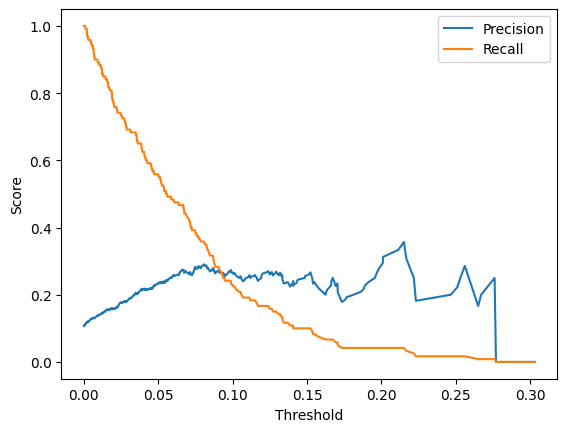

In [25]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get probabilities
y_probs = model.predict(val_gen)   # predicted probabilities
y_true = val_df[all_labels].values # true labels (multi-label) - Use val_df instead of df

# Example for one class (say class 0)
prec, rec, thresh = precision_recall_curve(y_true[:, 0], y_probs[:, 0])

plt.plot(thresh, prec[:-1], label="Precision")
plt.plot(thresh, rec[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()

In [26]:
model.save("over_aug_cnn_model.h5")
from google.colab import files
files.download("over_aug_cnn_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
y_probs = model.predict(val_gen)
y_pred = (y_probs[:,0] > 0.1).astype(int)  # for class 0
from sklearn.metrics import classification_report

print(classification_report(y_true[:,0], y_pred))


36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 433ms/step
              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1002
           1       0.26      0.23      0.24       120

    accuracy                           0.85      1122
   macro avg       0.59      0.57      0.58      1122
weighted avg       0.84      0.85      0.84      1122

